# Indexing EnergyData Catalog
Example notebook on how to index energydata ino

In [1]:
import json
from datetime import datetime
from pathlib import Path

import contextily as cx
import pandas as pd
import requests
from bs4 import BeautifulSoup
from h3ronpy.arrow import cells_parse
from h3ronpy.pandas.vector import cells_dataframe_to_geodataframe

from worldex.datasets.energydata import EnergyDataDataset

In [2]:
# fetch data
url = 'https://energydata.info/api/3/action/package_search?rows=10000'
response = requests.get(url)
datasets = response.json()['result']['results']



In [3]:
datasets_w_geo = []
for d in datasets:
    if any(r['format'] in ['GeoJSON', 'SHP ZIP', 'GPKG', 'SHP'] for r in d['resources']):
        datasets_w_geo.append(d)

In [10]:
data = datasets_w_geo[1]
data

{'author': 'Fang Fang, Daron Bedrosyan, Clara Ivanescu',
 'author_email': 'fang.fang@neo.nl, dbedrosyan@worldbank.org, civanescu@worldbank.org',
 'country_code': ['ETH'],
 'creator_user_id': 'ac5e2088-0f44-420b-ba13-73c045dc4033',
 'end_date': '',
 'group': 'Technical Rooftop Solar Potential Assessment',
 'id': '4ab91bb0-9e03-4d18-978d-8e4d110271e8',
 'isopen': True,
 'license_id': 'CC-BY-4.0',
 'license_title': 'Creative Commons Attribution 4.0',
 'license_url': 'https://creativecommons.org/licenses/by/4.0/',
 'metadata_created': '2020-11-24T13:54:33.892745',
 'metadata_modified': '2022-04-15T15:36:18.343471',
 'name': 'addis-abeba-rooftop-solar-potential-mapping',
 'notes': 'This dataset contains solar rooftop potential data (suitable rooftop area, installable capacity, estimated yearly electricity generation, and building type ) at individual building structure level for a sample area of interest in Addis Ababa. The data was gathered by extracting building rooftop footprint polygons

In [11]:
path = Path(f"../data/energydata/{data['name']}")
path.mkdir(parents=True, exist_ok=True)

In [12]:
energyinfo_dataset = EnergyDataDataset.from_dataset(data)
energyinfo_dataset.set_dir(path)
energyinfo_dataset.index()


,h3_index
0,88529b4de7fffff
1,88529b4d81fffff
2,88529b4d03fffff
3,88529b4e87fffff
4,88529b4ea5fffff
...,...
416,88529b79e9fffff
417,88529b4e91fffff
418,887acb4a39fffff
419,88529b7b2bfffff


In [13]:
with open(path / "metadata.json") as f:
    metadata = json.load(f)

metadata

{'id': 'b1a49d30-950d-4ae8-a471-5f11e4ce6a32',
 'name': 'Addis Ababa - Rooftop Solar Potential Mapping',
 'source_org': 'EnergyInfo',
 'last_fetched': '2024-03-22T10:05:11.838877',
 'files': ['https://energydata.info/dataset/4ab91bb0-9e03-4d18-978d-8e4d110271e8/resource/80b6ca4f-b41b-4c94-9c7e-1dfd00451515/download/addisabeba_rooftop_potential.zip',
  'https://energydata.info/dataset/4ab91bb0-9e03-4d18-978d-8e4d110271e8/resource/6b8f02d3-5b34-497d-9874-b252bb1440de/download/addisabeba_result_metadata.xlsx',
  'https://energydata.info/dataset/4ab91bb0-9e03-4d18-978d-8e4d110271e8/resource/2a3572b9-4d01-47d7-8238-dd47cd9ef549/download/addisababa_rooftop_solarpotential_v1.csv'],
 'description': 'This dataset contains solar rooftop potential data (suitable rooftop area, installable capacity, estimated yearly electricity generation, and building type ) at individual building structure level for a sample area of interest in Addis Ababa. The data was gathered by extracting building rooftop foo

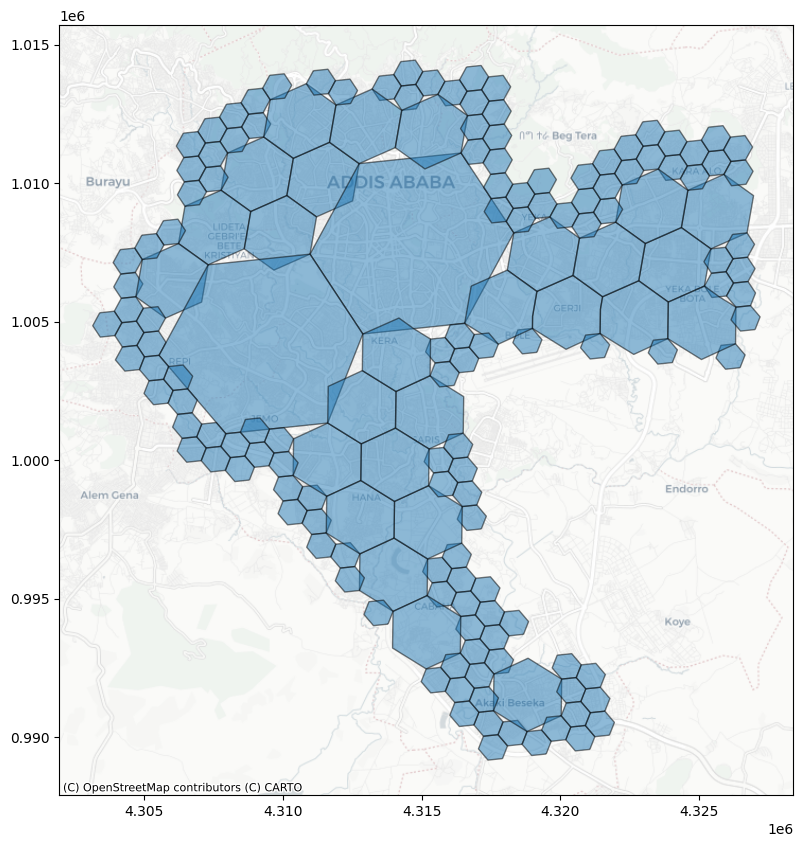

In [14]:
h3 = pd.read_parquet(path / "h3-compact.parquet")

h3_gdf = cells_dataframe_to_geodataframe(
    pd.DataFrame({"cell": cells_parse(h3.h3_index)})
)
h3_gdf_reprojected = h3_gdf.to_crs(epsg=3857)
ax = h3_gdf_reprojected.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)